### Preliminary
* get model (trained) and test it
* graph the result
* This uses the difference between days to establish the data (and loss)
* reads json file in
* The training figures were stored in Offline6
* The data is log(x+1) transformed

In [1]:
import torch
import pandas as pd
import numpy as np
import os
import copy
#import writer
import random
from sklearn.preprocessing import normalize
import subprocess
import seaborn as sns
import json
import math

#import 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [2]:
# read data in
csse_country = "CPSC540_Covid/active_data/csse_world_normalized.csv"
df_csse = pd.read_csv(csse_country)
df_csse.head(10)
#list(df_csse.columns.values.tolist()) 
countries = df_csse["Country/Region"].tolist()
validation_d = 5
test_d = 5

# Convert to numpy array

cases = df_csse.loc[:,'1/22/20':]
casesA = cases.to_numpy()
casesA
count, days = casesA.shape

print(days)
# last 10 days for test

case_test = casesA[:,-test_d:]
case_validation = casesA[:,days-validation_d-test_d:days-test_d]
case_train = casesA[:,:days-validation_d-test_d]

print(case_test.shape)
print(case_validation.shape)
print(case_train.shape)

84
(172, 5)
(172, 5)
(172, 74)


In [3]:
def find_zero(lst):
    numzero = 0
    for i in lst:
        if i ==0:
            numzero += 1
    return(numzero)

# graph number of days zero
cutoff = 25 # at most = 0
lstzero = []
skip_countries = []
for i in range(len(countries)):
    numz = find_zero(casesA[i,:].tolist())
    lstzero.append(numz)
    if numz > cutoff:
        skip_countries.append(i)

#sns.distplot(np.array(lstzero));

In [4]:
len(skip_countries)

149

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)
pred_days = test_d
# LSTM structure

class LSTM(nn.Module):
 
    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=pred_days,
                    num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
 
        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers,dropout=0)
 
        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)
 
    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
 
    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
        
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        
        return y_pred.view(-1)

    


In [6]:
def test_model(test_loader, model, device,criterion):
    #predictions = torch.zeros(0, numClass)
    test_loss = 0.0
    
    with torch.no_grad():
        model.eval()
        for i, (seqs, labels) in enumerate(test_loader):            
            seqs = seqs.to(device)
            y = labels.to(device).float()
            print(y)
            pred = model(seqs).float()
            print(pred)
            loss = criterion(pred, y)
            test_loss += loss.item() 
            
    return pred,test_loss




In [7]:
countries

['Burundi',
 'Djibouti',
 'Eritrea',
 'Ethiopia',
 'Kenya',
 'Madagascar',
 'Malawi',
 'Mauritius',
 'Mozambique',
 'Rwanda',
 'Seychelles',
 'Somalia',
 'South Sudan',
 'Uganda',
 'Tanzania',
 'Zambia',
 'Zimbabwe',
 'Angola',
 'Cameroon',
 'Central African Republic',
 'Chad',
 'Equatorial Guinea',
 'Gabon',
 'Sao Tome and Principe',
 'Botswana',
 'Eswatini',
 'Namibia',
 'South Africa',
 'Benin',
 'Burkina Faso',
 'Cabo Verde',
 'Gambia',
 'Ghana',
 'Guinea',
 'Guinea-Bissau',
 'Liberia',
 'Mali',
 'Mauritania',
 'Niger',
 'Nigeria',
 'Senegal',
 'Sierra Leone',
 'Togo',
 'Algeria',
 'Egypt',
 'Libya',
 'Morocco',
 'Sudan',
 'Tunisia',
 'Western Sahara',
 'Armenia',
 'Azerbaijan',
 'Bahrain',
 'Cyprus',
 'Georgia',
 'Iraq',
 'Israel',
 'Jordan',
 'Kuwait',
 'Lebanon',
 'Oman',
 'Qatar',
 'Saudi Arabia',
 'Syria',
 'Turkey',
 'United Arab Emirates',
 'Yemen',
 'Kazakhstan',
 'Kyrgyzstan',
 'Uzbekistan',
 'Afghanistan',
 'Bangladesh',
 'Bhutan',
 'India',
 'Iran',
 'Maldives',
 'Nepal'

In [8]:
import matplotlib.pyplot as plt

def graph_country(index,prediction,outdir):
    print(index)
    print(countries[index])
    
    # produce projection closeup & general graph
    # with label & title
    #print(prediction)
    newpred = prediction#.tolist()
    
    # general trend
    x = np.linspace(1, len(casesA[index,:].tolist()), len(casesA[index,:].tolist()))
    y_real = casesA[index,:]
    y_pred = casesA[index,:days-test_d].tolist()
    #print(len(y_pred))
    y_pred.extend(newpred)
    #print(len(y_pred))
    #print(len(y_real))
    y_pred = np.array(y_pred)
    
    # 
    plt.figure(index)
    ax = plt.subplot(111)    
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False) 
    #
    plt.plot(x, y_real,':', label = "Real",color = "crimson")
    plt.plot(x, y_pred, label = "Prediction", color = "teal")
    
    plt.xlabel('Days')
    plt.title(countries[index]+" trend")
    
    plt.legend(frameon=False)
    
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()  
    
    ax.axvspan(x[-test_d-1], x[-1],color = "coral",alpha = 0.3)
    
    plt.savefig(outdir+countries[index]+"_general",dpi=300)
    
    plt.show()
    # specific plot
    x = np.linspace(1, len(casesA[index,days-test_d:].tolist()), len(casesA[index,days-test_d:].tolist()))
    y_real = casesA[index,days-test_d:]
    y_pred = newpred
    plt.figure(index*2)
    ax = plt.subplot(111)    
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False) 

    plt.plot(x, y_real,':', label = "Real",color = "crimson")
    plt.plot(x, y_pred, label = "Prediction", color = "teal")
    
    plt.xlabel('Days')
    plt.title(countries[index]+" 5 days prediction")
    
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()
    plt.legend(frameon=False)
    
    plt.savefig(outdir+countries[index]+"_specific",dpi=300)    
    plt.show()

In [9]:

b = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16819754465224315, 0.16819754465224315, 0.25229631697836474, 0.25229631697836474, 0.25229631697836474]
print(len(b))
print(b)
print(len(b))

b[-3]

74
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16819754465224315, 0.16819754465224315, 0.25229631697836474, 0.25229631697836474, 0.25229631697836474]
74


0.25229631697836474

In [10]:

import json
with open("./country_summary_7.js",'r') as outfile:
    dt = json.load(outfile)

In [11]:
test_d

5

In [12]:
def chain_val(start,array):
    lst = array.tolist()
    newlst = []
    for i in range(len(lst)):
        if i == 0:
            newlst.append(lst[i]+start)
            continue
        newlst.append(newlst[i-1] + lst[i])
    return(newlst)

chain_val(1,np.array([2,3,4]))

[3, 6, 10]

In [13]:
{"*Taiwan":0,"US":0,"Italy":0, "Korea, South":0,"Germany":0,"Japan":0}

{'*Taiwan': 0,
 'US': 0,
 'Italy': 0,
 'Korea, South': 0,
 'Germany': 0,
 'Japan': 0}

Directory ./graph_offline7/ exists
[3.1660056114196777, 3.374738931655884, 4.065228462219238, 3.4669930934906006, 4.352020263671875]
163
Belgium


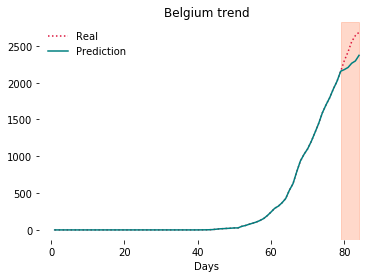

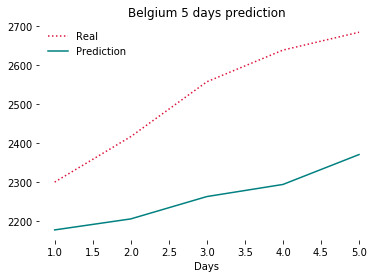

[2178.34839663 2206.56505188 2263.84327325 2294.88352865 2371.51867672] [2231.22069576 2333.81249774 2453.22970037 2575.92569903 2719.24359901]
Belgium
50950.38687725043
[0.0, 0.13754040002822876, 0.0, 0.1331545114517212, 0.09317321330308914]
84
Cambodia


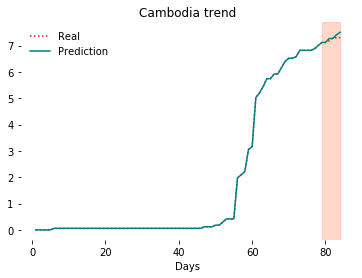

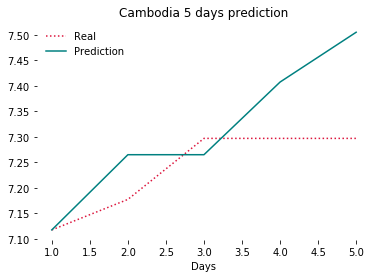

[7.11766335 7.26511141 7.26511141 7.40753791 7.50518976] [7.23728794 7.23728794 7.29710024 7.53634943 7.53634943]
Cambodia
0.006734161060011126
[0.12832781672477722, 0.0, 0.0, 0.04327113926410675, 0.0]
170
Diamond Princess


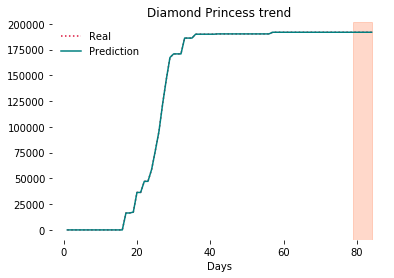

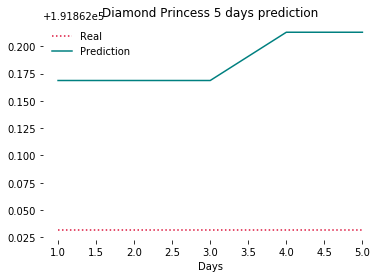

[191862.168723   191862.168723   191862.168723   191862.21294399
 191862.21294399] [191862.03179736 191862.03179736 191862.03179736 191862.03179736
 191862.03179736]
Diamond Princess
0.024374820047697855
[0.22553157806396484, 0.24138149619102478, 0.3457607328891754, 0.27587637305259705, 0.2638724148273468]
44
Egypt


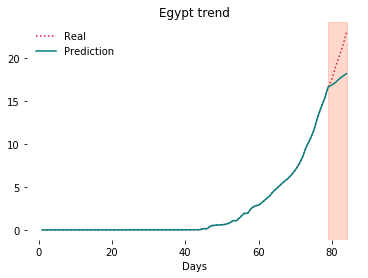

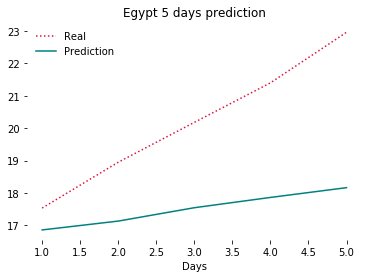

[16.85542141 17.128428   17.54149247 17.85917743 18.1611395 ] [17.1301146  17.80437468 18.6447568  19.81738301 20.64799325]
Egypt
2.353712616949892
[2.7904934883117676, 3.5306167602539062, 2.757768154144287, 2.7993648052215576, 2.740159034729004]
140
Finland


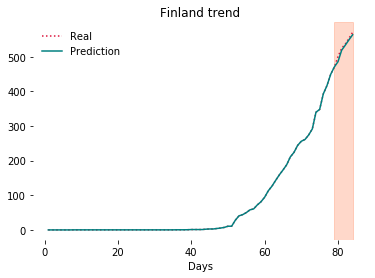

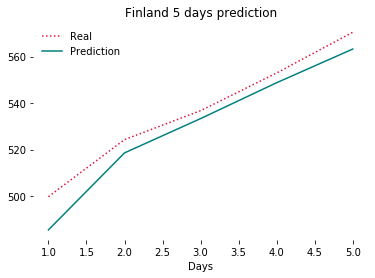

[485.44455953 518.58957995 533.3541994  548.78840394 563.2778522 ] [482.06731255 487.1208074  500.11550845 517.62225848 565.81094154]
Finland
616.849036554245
[3.866262197494507, 4.406240463256836, 4.078502655029297, 4.383838653564453, 4.489906311035156]
164
Germany


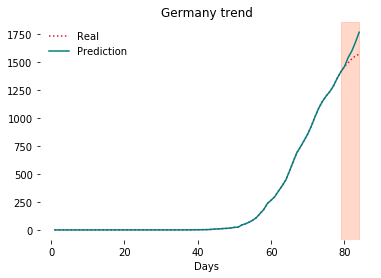

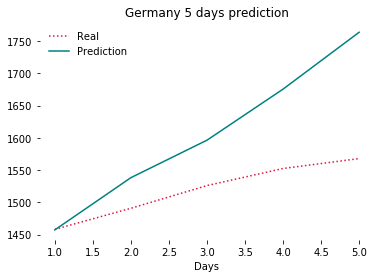

[1457.30814241 1538.26889152 1596.32586647 1675.4709594  1763.58405597] [1469.30289154 1541.67952215 1624.2967776  1700.26598173 1759.14360686]
Germany
314.47779966139785
[0.0, 0.08575455099344254, 0.05532125383615494, 0.026597078889608383, 0.1281672716140747]
73
India


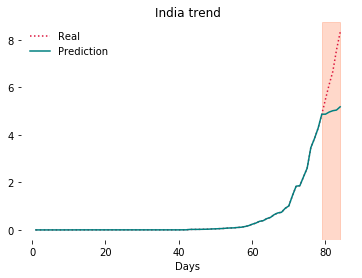

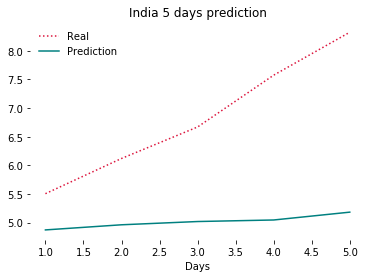

[4.8731729  4.96271177 5.01959186 5.0465458  5.18328893] [4.97896967 5.41447553 5.80940181 5.82679306 6.19998028]
India
0.4963060575542704
[4.704124927520752, 4.012953281402588, 4.578251838684082, 5.072092533111572, 3.984114170074463]
153
Italy


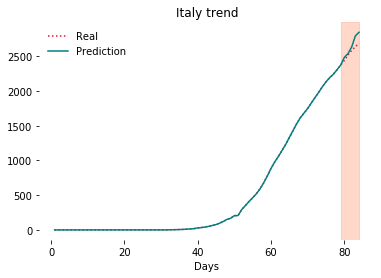

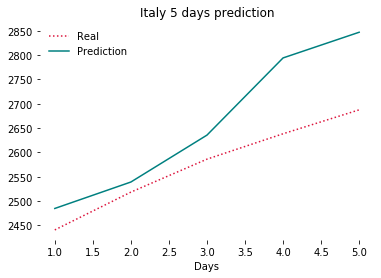

[2484.88381761 2539.19379313 2635.53786537 2794.04561899 2846.78328495] [2442.51621229 2521.60743398 2598.81316857 2674.64613625 2754.11776322]
Italy
5259.226551868999
[0.4575265944004059, 0.0, 0.4119115471839905, 0.337714821100235, 0.5990694761276245]
81
Japan


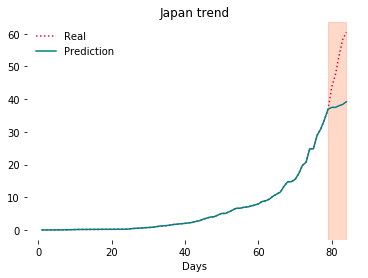

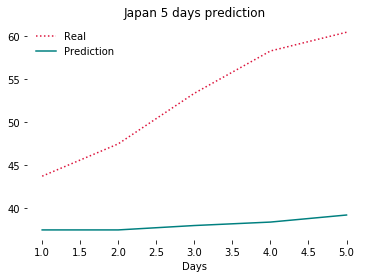

[37.48030804 37.48030804 37.99000893 38.39174963 39.21217369] [37.58802231 39.36700948 41.87340474 42.83801112 46.96526136]
Japan
19.706323471805337
[1.729121208190918, 1.212872862815857, 1.459783911705017, 1.513251543045044, 1.4847891330718994]
80
Korea, South


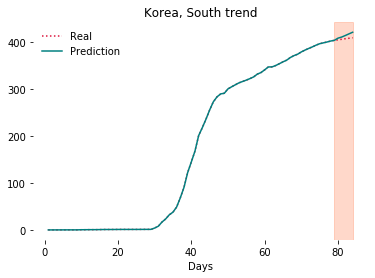

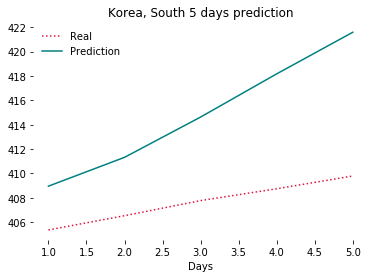

[408.95986912 411.32300173 414.62803089 418.1695045  421.58353904] [409.17311188 413.09105692 416.54350354 419.87957556 423.52597985]
Korea, South
2.707589294449467
[1.5253887176513672, 1.95930814743042, 1.9870617389678955, 1.4057172536849976, 1.6951401233673096]
87
Malaysia


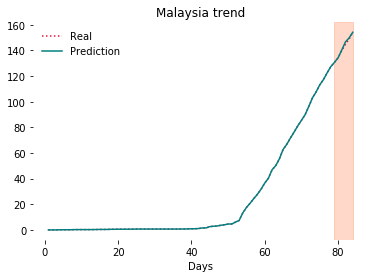

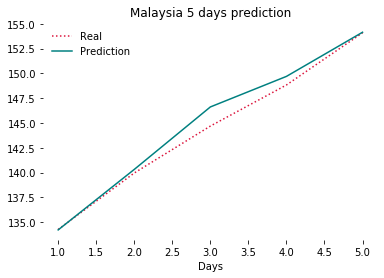

[134.22783911 140.32225618 146.61632655 149.69477752 154.14218674] [134.95643577 139.34375579 145.77025273 152.47481925 157.10931224]
Malaysia
3.7473245483623274
[0.0, 0.0016314461827278137, 0.0033987611532211304, 0.0, 0.0]
76
Nepal


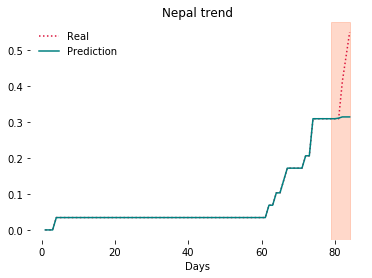

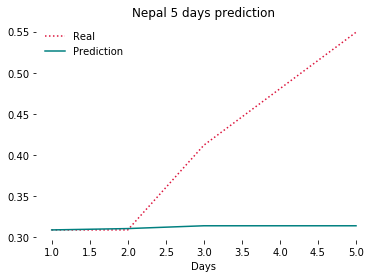

[0.30888762 0.3105204  0.31392494 0.31392494 0.31392494] [0.30888762 0.30888762 0.34320847 0.34320847 0.44617101]
Nepal
0.0038413475977803666
[0.975165843963623, 0.9784367084503174, 1.0557162761688232, 1.4559992551803589, 1.8201301097869873]
88
Philippines


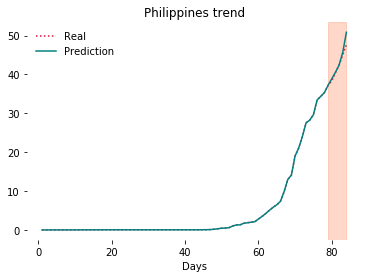

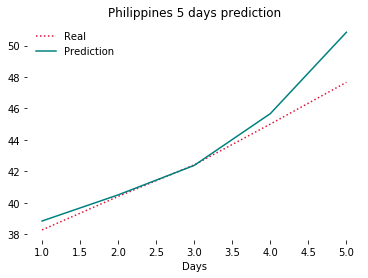

[38.84780565 40.50809983 42.38213284 45.67089974 50.84356126] [42.10580493 44.17733023 47.11579343 50.62917334 51.32272366]
Philippines
14.259885453048852
[0.01966157555580139, 1.3640410900115967, 1.6315453052520752, 1.9288907051086426, 0.21487408876419067]
136
Russia


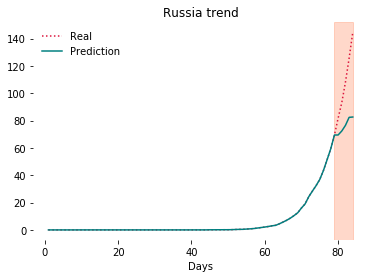

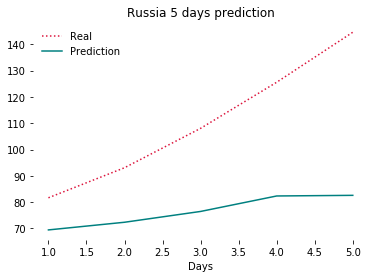

[69.44143073 72.35340075 76.46516861 82.34704059 82.58674639] [72.85462255 75.86967465 81.15286821 85.27115528 89.25924692]
Russia
19.812259643126577
[2.4601340293884277, 2.0312819480895996, 2.2474260330200195, 2.1024155616760254, 2.2289798259735107]
89
Singapore


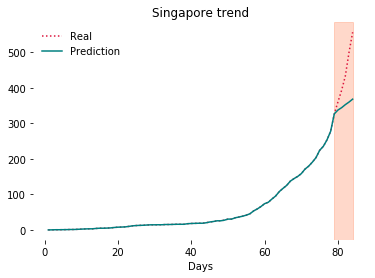

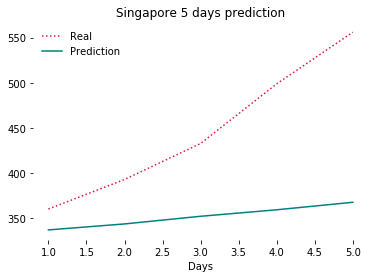

[337.18313221 343.80698569 352.27033181 359.45625146 367.74663489] [334.5104729  347.1593104  355.53489199 366.64535736 379.4651251 ]
Singapore
43.60895969016472
[5.534633159637451, 5.41276741027832, 5.428792953491211, 5.535823822021484, 5.393906116485596]
161
Spain


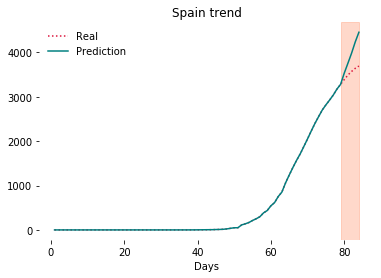

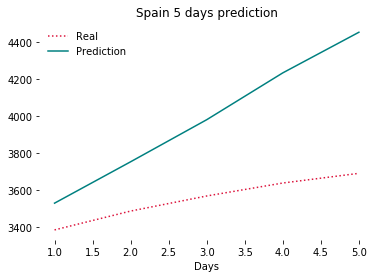

[3529.4557058  3752.70703097 3979.58105578 4232.19769235 4451.25898632] [3447.54055093 3622.81674729 3792.78867316 3945.37200261 4094.42628112]
Spain
53614.30567891421
[0.15530087053775787, 0.0, 0.11915656924247742, 0.1344844102859497, 0.13618779182434082]
78
Sri Lanka


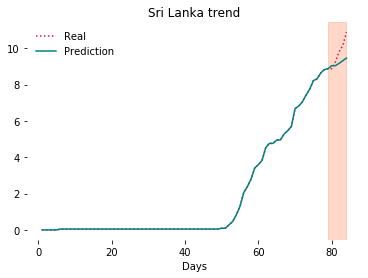

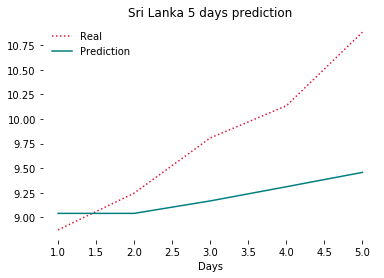

[9.0410202  9.0410202  9.16756648 9.31151331 9.45741037] [ 9.85371207  9.99381224 10.22731253 10.60091299 10.92781339]
Sri Lanka
1.3031957980387223
[3.0549259185791016, 3.2393410205841064, 3.368020534515381, 3.566420078277588, 3.4445371627807617]
146
Sweden


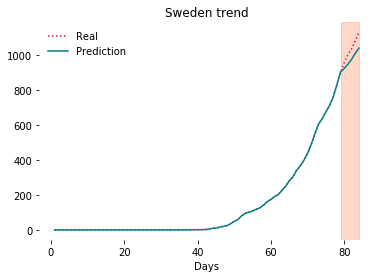

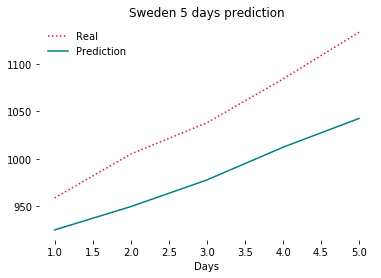

[ 925.33453764  949.85143873  977.87246278 1012.26213662 1042.59091659] [ 945.41486662  996.11160015 1057.60119296 1113.34779642 1144.24111842]
Sweden
5890.193342242403
[0.40097135305404663, 0.40934401750564575, 0.4659954309463501, 0.4210006594657898, 0.4295995235443115]
79
Taiwan*


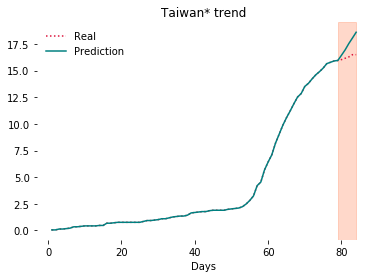

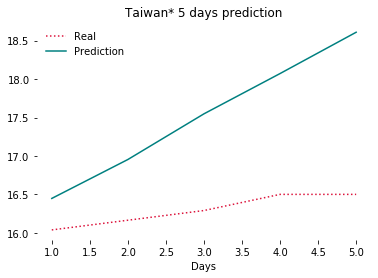

[16.448412   16.95424167 17.54784138 18.07132667 18.60796868] [16.62693278 16.9208432  17.34071524 17.71860008 18.01251051]
Taiwan*
0.11097456806686339
[1.1480709314346313, 1.1707251071929932, 1.205428957939148, 1.226645827293396, 1.2971162796020508]
90
Thailand


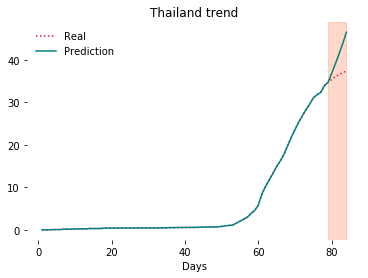

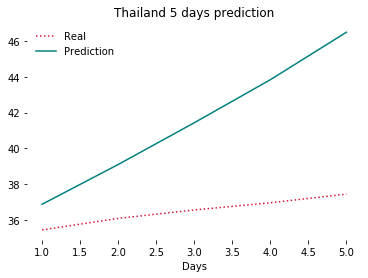

[36.86558341 39.08991318 41.4281039  43.83787726 46.49660795] [36.53296176 38.25215996 39.74213173 41.21777685 42.49284885]
Thailand
5.309996562260361
[3.993164539337158, 4.025872230529785, 4.099206447601318, 4.407008171081543, 4.329497337341309]
169
US


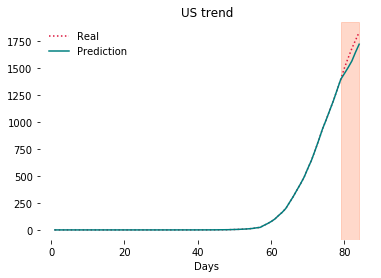

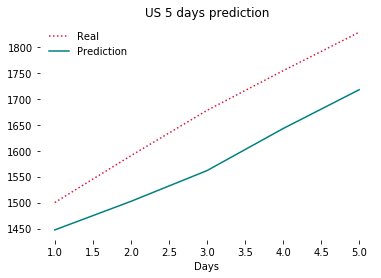

[1447.28454465 1502.31370247 1561.60612588 1642.62982105 1717.53594286] [1473.63774882 1549.77006982 1641.58202359 1737.72626896 1838.22999604]
US
6590.626253164625
[0.05238018184900284, 2.8831698894500732, 2.8058013916015625, 1.9976067543029785, 2.7570343017578125]
65
United Arab Emirates


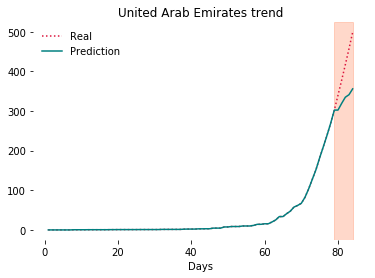

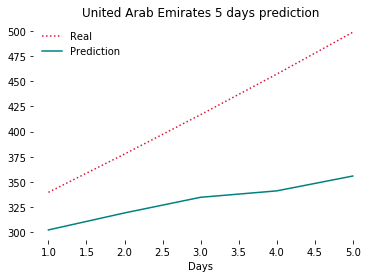

[302.36713066 319.23796271 334.77828858 341.149682   355.90273679] [307.67208606 322.83830785 344.07101836 368.33697323 392.70403624]
United Arab Emirates
444.1888617411429
[0.05648522824048996, 0.05914926528930664, 0.11682555824518204, 0.11033645272254944, 0.07566788792610168]
92
Vietnam


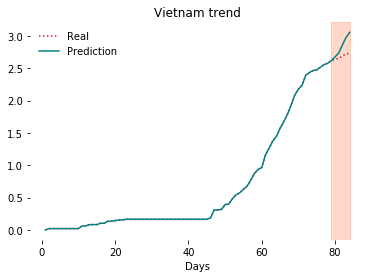

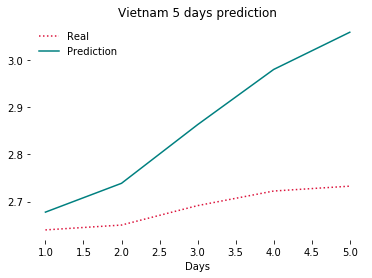

[2.67783278 2.73876637 2.86268973 2.97934344 3.05794773] [2.71218257 2.77382308 2.92792436 2.96901804 2.9998383 ]
Vietnam
0.0020295517679213325


In [14]:
len(dt)

lr_dict=dict()
layerLst = []
stateLst = []
momentumLst = []
mseLst = []
nloss = []

keyCountry = {"*Taiwan":0,"US":0,"Italy":0, "Korea, South":0,"Germany":0,"Japan":0}

country_result = dict()
graph_dir = "./graph_offline7/"
directory = os.path.dirname(graph_dir)
if not os.path.exists(directory):
    print("Creating directory %s" % graph_dir)
    os.makedirs(directory)
else:
     print("Directory %s exists" % graph_dir)

for key,item in dt.items():
    # [hyperparam, [prediction, truth], error]
    # [lr, layer, state, momentum]111
    ind = countries.index(key)
    
    # hyper-param
    if item[0][0] in lr_dict:
        lr_dict[item[0][0]] += 1
    else:
        lr_dict[item[0][0]] = 1
    layerLst.append(item[0][1])
    stateLst.append(item[0][2])
    momentumLst.append(item[0][3])
    
    
    # get original
    print(item[1][0])
    startv = casesA[ind,-test_d-1]
    pred = chain_val(startv,np.exp(np.array(item[1][0]))-1)
    y = chain_val(startv,np.exp(np.array(item[1][1]))-1)
    
    # graph
    graph_country(ind,pred,graph_dir)
    
    # mse calculation
    a = np.array(pred)
    b = np.array(y)
    print(a,b)
    mse = ((a-b)**2).mean()
    print(key)
    print(str(mse))
    keyCountry[key] = mse
    mseLst.append(mse)
    nloss.append(mse/max(y))

### Show result:
* distribution of the hyper-parameter
* MSE distribution (histogram)
* MSE normalized to max of value (histogram)

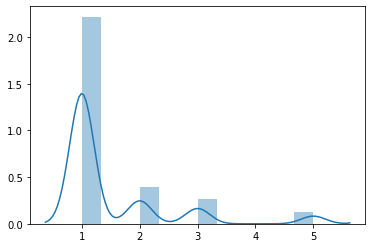

In [15]:
sns.distplot(np.array(layerLst));


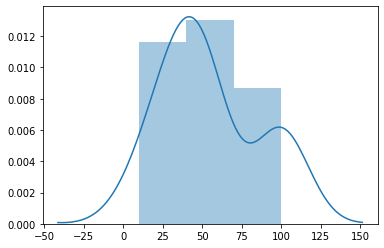

In [16]:
sns.distplot(np.array(stateLst));

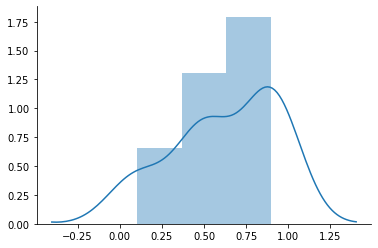

In [22]:
sns.distplot(np.array(momentumLst))
sns.despine()
plt.show()


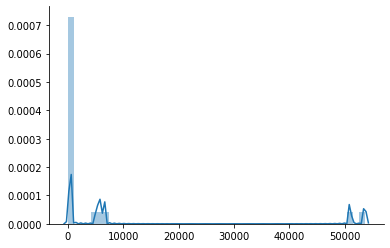

In [23]:
sns.distplot(np.array(mseLst))
sns.despine()
plt.show()

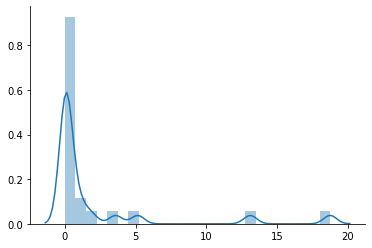

In [24]:

sns.distplot(np.array(nloss))
sns.despine()
plt.show()

In [20]:
keyCountry

{'*Taiwan': 0,
 'US': 6590.626253164625,
 'Italy': 5259.226551868999,
 'Korea, South': 2.707589294449467,
 'Germany': 314.47779966139785,
 'Japan': 19.706323471805337,
 'Belgium': 50950.38687725043,
 'Cambodia': 0.006734161060011126,
 'Diamond Princess': 0.024374820047697855,
 'Egypt': 2.353712616949892,
 'Finland': 616.849036554245,
 'India': 0.4963060575542704,
 'Malaysia': 3.7473245483623274,
 'Nepal': 0.0038413475977803666,
 'Philippines': 14.259885453048852,
 'Russia': 19.812259643126577,
 'Singapore': 43.60895969016472,
 'Spain': 53614.30567891421,
 'Sri Lanka': 1.3031957980387223,
 'Sweden': 5890.193342242403,
 'Taiwan*': 0.11097456806686339,
 'Thailand': 5.309996562260361,
 'United Arab Emirates': 444.1888617411429,
 'Vietnam': 0.0020295517679213325}

In [38]:
a = np.array([2178.34839663 ,2206.56505188, 2263.84327325 ,2294.88352865, 2371.51867672])
b = np.array([2231.22069576, 2333.81249774 ,2453.22970037 ,2575.92569903 ,2719.24359901])
np.mean((b-a)**2)

50950.38687679051